In [1]:
 !pip3 install imbalanced-learn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
!pip3 install xgboost

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
!pip3 install lime

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [104]:
!pip3 install gunicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 5.4 MB/s eta 0:00:00
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import dill
dill.load_session('score_credit_4.p')

## Import des Modules

In [102]:
import dill
import pickle
import numpy as np
import pandas as pd
import gc
import time
import xgboost as xgb

from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import lime
import lime.lime_tabular

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns',None)

## Fonctions Diverses

#### Fonction d'optimisation mémoire d'un dataframe

In [6]:
def optimize_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Fonction de calcul de taux de valeurs manquantes

In [7]:
def get_missing_values(df,seuil):

    di_temp={ "Missing Tot. val.": df.isnull().sum(),
           "Missing % val.": 100*df.isnull().sum() / len(df) }
    df_temp= pd.DataFrame(di_temp)
    df_temp=df_temp[df_temp["Missing % val."] >= seuil]
    df_temp.sort_values(by=['Missing % val.'], inplace=True,ascending=False)
    
    return df_temp

#### Fonction de calcul de taux de remplissage

In [8]:
def get_fill_values(df,seuil):

    di_temp={ "Missing Tot.": df.isnull().sum(),
           "Missing %": 100*df.isnull().sum() / len(df) }
    df_temp= pd.DataFrame(di_temp)
    df_temp=df_temp[df_temp["Missing %"] < seuil]
    df_temp.sort_values(by=['Missing %'], inplace=True,ascending=False)
    
    return df_temp

## Analyse Exploratoire et Feature Engineering

### Définition du Kernel 

On ajoutte les Features suivantes :

- N_DAYS_EMPLOYED_PERCENT = DAYS_EMPLOYED / DAYS_BIRTH : Taux d'emploiement
- N_FLAG_TOT_DOC = FLAG_DOCUMENT_2 + FLAG_DOCUMENT FLAG_DOCUMENT + ... + FLAG_DOCUMENT_12
- N_FLAG_TOT_PHONE = FLAG_MOBIL+ FLAG_EMP_PHONE + FLAG_WORK_PHONE FLAG_PHONE
- N_FLAG_AT_LEAST_1_PHONE = FLAG_MOBIL or  FLAG_EMP_PHONE or FLAG_WORK_PHONE or FLAG_PHONE 

In [9]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

l_cat=[]

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    print('one_hot_encoder',nan_as_category)
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    print('application_train_test',nan_as_category)
    # Read data and merge
    df = optimize_memory_usage(pd.read_csv('application_train.csv', nrows= num_rows))
    test_df = optimize_memory_usage(pd.read_csv('application_test.csv', nrows= num_rows))
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
  
    df['N_FLAG_TOT_DOC']=df.filter(like='FLAG_DOCUMENT').sum(axis=1) 
    df.drop([col for col in df.columns if col.startswith('FLAG_DOCUMENT')], axis=1, inplace=True)  
    df['N_FLAG_TOT_PHONE']=df['FLAG_MOBIL']+df['FLAG_EMP_PHONE']+df['FLAG_WORK_PHONE']+df['FLAG_PHONE']
    df['N_FLAG_AT_LEAST_1_PHONE']=df[['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']].any(axis=1).map(lambda x: x+1-1)
    df.drop(['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE'], axis=1, inplace=True)  
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    for c in cat_cols:
        l_cat.append(c)
    print(l_cat)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    print('bureau_and_balance', nan_as_category)
    bureau = optimize_memory_usage(pd.read_csv('bureau.csv', nrows = num_rows))
    bb = optimize_memory_usage(pd.read_csv('bureau_balance.csv', nrows = num_rows))
    bb, bb_cat = one_hot_encoder(bb, nan_as_category) 
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    for c in cat_aggregations.items():
        l_cat.append('BURO'+'_'+c[0]+'_'+c[1][0].upper()) 
    print(l_cat)
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    print('previous_applications',nan_as_category)
    prev = optimize_memory_usage(pd.read_csv('previous_application.csv', nrows = num_rows))
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    for c in cat_aggregations.items():
        l_cat.append('PREV'+'_'+c[0]+'_'+c[1][0].upper())
    print(l_cat)
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    print('pos_cash',nan_as_category)
    pos = optimize_memory_usage(pd.read_csv('POS_CASH_balance.csv', nrows = num_rows))
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    aggregations_sav = aggregations.copy()
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    #print('aggregations[cat]',aggregations)
    #print('')
    #print('aggregations_sav.keys() :',aggregations_sav.keys())
    #print('')
    for c in aggregations.items():
        #print("c[0]",c[0])
        if c[0] not in aggregations_sav.keys():
            l_cat.append('POS'+'_'+c[0]+'_'+c[1][0].upper())
    print(l_cat)
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    print('installments_payments',nan_as_category)
    ins = optimize_memory_usage(pd.read_csv('installments_payments.csv', nrows = num_rows))
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    aggregations_sav = aggregations.copy()
   
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    #print("cat_cols",cat_cols)
    #print('aggregations[cat]',aggregations)
    #print('')
    #print('aggregations_sav.keys() :',aggregations_sav.keys())
    #print('')
    for c in aggregations.items():
        #print("c[0]",c[0])
        if c[0] not in aggregations_sav.keys():
            l_cat.append('INSTAL_'+'_'+c[0]+'_'+c[1][0].upper())
    print(l_cat)
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    print('credit_card_balance',nan_as_category)
    cc = optimize_memory_usage(pd.read_csv('credit_card_balance.csv', nrows = num_rows))
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= False)
    
    #print('cat_cols : ',cat_cols)
    l_agg=['min', 'max', 'mean', 'sum', 'var']
    for c in cat_cols:
        for agg in l_agg:
            l_cat.append('CC'+'_'+c+'_'+agg.upper())
    print(l_cat)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

def df_credit(debug = False,nan_as_category = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows, nan_as_category)
    print("len application_train_test = ",len(df))
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows, nan_as_category)
        print("Bureau df shape:", bureau.shape)
        print("len bureau = ",len(bureau))
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print('len join(app_train_test+bureau) = ',len(df))
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows, nan_as_category)
        print("Previous applications df shape:", prev.shape)
        print("len previous_applications = ",len(prev))
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print('len join(app_train_test+bureau+prev_app) = ',len(df))
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows, nan_as_category)
        print("Pos-cash balance df shape:", pos.shape)
        print("len pos = ",len(pos))
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print('len join(app_train_test+bureau+prev_app+pos)  = ',len(df))
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows, nan_as_category)
        print("Installments payments df shape:", ins.shape)
        print("len ins = ",len(ins))
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print('len join(app_train_test+bureau+prev_app+pos+ins) = ',len(df))
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows, nan_as_category)
        print("Credit card balance df shape:", cc.shape)
        print("len cc = ",len(cc))
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print('len join(app_train_test+bureau+prev_app+pos+ins+cc) = ',len(df))
        del cc
        gc.collect()
    #with timer("Run LightGBM with kfold"):
    #    feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

    return df

#### Exécution du Kernel

In [10]:
df = df_credit(debug = False, nan_as_category = False)
df

application_train_test False
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Train samples: 307511, test samples: 48744
one_hot_encoder False
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary',

Bureau df shape: (305811, 112)
len bureau =  305811
len join(app_train_test+bureau) =  356251
Process bureau and bureau_balance - done in 24s
previous_applications False
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
one_hot_encoder False
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'N

Previous applications df shape: (338857, 233)
len previous_applications =  338857
len join(app_train_test+bureau+prev_app) =  356251
Process previous_applications - done in 26s
pos_cash False
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
one_hot_encoder False
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYP

Pos-cash balance df shape: (337252, 17)
len pos =  337252
len join(app_train_test+bureau+prev_app+pos)  =  356251
Process POS-CASH balance - done in 14s
installments_payments False
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
one_hot_encoder True
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower seco

Installments payments df shape: (339587, 26)
len ins =  339587
len join(app_train_test+bureau+prev_app+pos+ins) =  356251
Process installments payments - done in 32s
credit_card_balance False
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
one_hot_encoder False
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYP

Credit card balance df shape: (103558, 136)
len cc =  103558
len join(app_train_test+bureau+prev_app+pos+ins+cc) =  356251
Process credit card balance - done in 24s


index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          121500.0    412560.0      17473.5   
356251             2          157500.0    622413.0      31909.5   
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018799       -9461   
1             1129500.0                    0.003542      -16765   
2              135000.0                    0.010033      -19046   
3              297000.0                    0.008018      -19005   
4              513000.0                    0.028656      -19932   
...                 ...                         ...         ...   
356250         270000.0                    0.002043      -19970   
356251         495000.0                    0.035797      -11186   
356252         315000.0                    0.026398      -15922   
356253         450000.0                    0.018845      -13968   
356254         270000.0                    0.006630      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9832.0            -2437          NaN   
4             -3038.0            -4312.0            -3458          NaN   
...               ...                ...              ...          ...   
356250        -5169.0            -9096.0            -3399          NaN   
356251        -1149.0            -3016.0            -3003          NaN   
356252        -3037.0            -2680.0            -1504          4.0   
356253        -2731.0            -1461.0            -1364          NaN   
356254         -633.0            -1072.0            -4220         22.0   

        FLAG_CONT_MOBILE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                      1           0              1.0                     2   
1                      1           0              2.0                     1   
2                      1           0              1.0                     2   
3                      1           0              2.0                     2   
4                      1           0              1.0                     2   
...                  ...         ...              ...         

### Réduction du nombre de Features

In [149]:
751-237

514

In [151]:
514 -74

440

In [152]:
751 - 237 - 74

440

#### Calcul % Missing Values

On calcule les Features ayant un % Missing Value >= 45 %

In [11]:
dfm=get_missing_values(df,45)

print("Total Missing Features :",len(dfm.index))
print("Total Features :",len(df.columns))

dfm

Total Missing Features : 237
Total Features : 751


Missing Tot. val.  Missing % val.
REFUSED_RATE_DOWN_PAYMENT_MAX             303648       85.234287
REFUSED_AMT_DOWN_PAYMENT_MIN              303648       85.234287
REFUSED_AMT_DOWN_PAYMENT_MAX              303648       85.234287
REFUSED_AMT_DOWN_PAYMENT_MEAN             303648       85.234287
REFUSED_RATE_DOWN_PAYMENT_MIN             303648       85.234287
...                                          ...             ...
FLOORSMAX_MODE                            176340       49.498808
YEARS_BEGINEXPLUATATION_MEDI              172862       48.522530
YEARS_BEGINEXPLUATATION_MODE              172862       48.522530
YEARS_BEGINEXPLUATATION_AVG               172862       48.522530
TOTALAREA_MODE                            171054       48.015023

[237 rows x 2 columns]

#### Calcul % Filled Values > 55%

In [12]:
pd.set_option('display.max_rows', 1000) 
dff=get_fill_values(df,45)

print("Total Filling Features :", len(dff.index))
print("Total Features :",len(df.columns))

dff

Total Filling Features : 514
Total Features : 751


Missing Tot.  Missing %
CLOSED_DAYS_CREDIT_VAR                                    150025  42.112162
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN                          143284  40.219957
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN                          138151  38.779119
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN                          126314  35.456462
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX                            116391  32.671066
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN                           116391  32.671066
ACTIVE_DAYS_CREDIT_ENDDATE_MIN                            114909  32.255067
ACTIVE_DAYS_CREDIT_ENDDATE_MAX                            114909  32.255067
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN                           114909  32.255067
APPROVED_APP_CREDIT_PERC_VAR                              107148  30.076547
ACTIVE_AMT_CREDIT_SUM_MAX                                 104443  29.317251
ACTIVE_AMT_CREDIT_SUM_MEAN                                104443  29.317251
ACTIVE_DAYS_CREDIT_MAX                                    104440  29.316409
ACTIVE_DAYS_CREDIT_MIN                                    104440  29.316409
ACTIVE_MONTHS_BALANCE_SIZE_SUM                            104440  29.316409
ACTIVE_CNT_CREDIT_PROLONG_SUM                             104440  29.316409
ACTIVE_AMT_CREDIT_SUM_SUM                                 104440  29.316409
ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN                        104440  29.316409
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM                           104440  29.316409
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM                            104440  29.316409
ACTIVE_CREDIT_DAY_OVERDUE_MEAN                            104440  29.316409
ACTIVE_CREDIT_DAY_OVERDUE_MAX                             104440  29.316409
ACTIVE_DAYS_CREDIT_UPDATE_MEAN                            104440  29.316409
ACTIVE_DAYS_CREDIT_MEAN                                   104440  29.316409
CLOSED_AMT_CREDIT_SUM_DEBT_MAX                            101919  28.608762
CLOSED_AMT_CREDIT_SUM_DEBT_MEAN                           101919  28.608762
BURO_DAYS_CREDIT_VAR                                       91964  25.814384
CLOSED_DAYS_CREDIT_ENDDATE_MIN                             90083  25.286385
CLOSED_DAYS_CREDIT_ENDDATE_MAX                             90083  25.286385
CLOSED_DAYS_CREDIT_ENDDATE_MEAN                            90083  25.286385
PREV_APP_CREDIT_PERC_VAR                                   88434  24.823509
CLOSED_DAYS_CREDIT_MAX                                     88330  24.794316
CLOSED_DAYS_CREDIT_MEAN                                    88330  24.794316
CLOSED_DAYS_CREDIT_UPDATE_MEAN                             88330  24.794316
CLOSED_CREDIT_DAY_OVERDUE_MAX                              88330  24.794316
CLOSED_CREDIT_DAY_OVERDUE_MEAN                             88330  24.794316
CLOSED_AMT_CREDIT_SUM_MEAN                                 88330  24.794316
CLOSED_AMT_CREDIT_SUM_SUM                                  88330  24.794316
CLOSED_AMT_CREDIT_SUM_DEBT_SUM                             88330  24.794316
CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN                         88330  24.794316
CLOSED_AMT_CREDIT_SUM_LIMIT_SUM                            88330  24.794316
CLOSED_CNT_CREDIT_PROLONG_SUM                              88330  24.794316
CLOSED_MONTHS_BALANCE_SIZE_SUM                             88330  24.794316
CLOSED_DAYS_CREDIT_MIN                                     88330  24.794316
CLOSED_AMT_CREDIT_SUM_MAX                                  88330  24.794316
BURO_AMT_CREDIT_SUM_LIMIT_MEAN                             75752  21.263660
EXT_SOURCE_3                                               69633  19.546050
DAYS_EMPLOYED                                              64648  18.146756
DAYS_EMPLOYED_PERC                                         64648  18.146756
BURO_AMT_CREDIT_SUM_DEBT_MEAN                              58816  16.509708
BURO_AMT_CREDIT_SUM_DEBT_MAX                               58816  16.509708
BURO_DAYS_CREDIT_ENDDATE_MAX                               53029  14.885292
BURO_DAYS_CREDIT_ENDDATE

#### 1iere Application de la Réduction du nombre de Features

On ne conserve pas les Features ayant 1 taux de Missing >= 45% donc on ne conserve les Features qu'avec 1 taux de remplissage > 55%

In [13]:
df=df[dff.index.tolist()].copy()
df

CLOSED_DAYS_CREDIT_VAR  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
0                123956.700000                       1681.029053   
1                820590.333333                          0.000000   
2                421362.000000                          0.000000   
3                          NaN                               NaN   
4                          NaN                          0.000000   
...                        ...                               ...   
356250           477960.333333                      11427.750000   
356251                     NaN                               NaN   
356252           153749.666667                          0.000000   
356253           623987.563636                       1492.488037   
356254                     NaN                          0.000000   

        ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN  CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN  \
0                           15994.282227                               0.0   
1                          810000.000000                               0.0   
2                                    NaN                               0.0   
3                                    NaN                               NaN   
4                                    NaN                               0.0   
...                                  ...                               ...   
356250                               NaN                               0.0   
356251                               NaN                               NaN   
356252                      29202.750000                               0.0   
356253                          0.000000                               0.0   
356254                      29134.193359                               0.0   

        ACTIVE_AMT_CREDIT_SUM_DEBT_MAX  ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN  \
0                         2.457810e+05                     1.228905e+05   
1                         0.000000e+00                     0.000000e+00   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   
...                                ...                              ...   
356250                    2.789010e+05                     2.782350e+05   
356251                             NaN                              NaN   
356252                    2.134350e+04                     2.134350e+04   
356253                    3.806041e+05                     1.312798e+05   
356254                    1.840308e+06                     1.116020e+06   

        ACTIVE_DAYS_CREDIT_ENDDATE_MIN  ACTIVE_DAYS_CREDIT_ENDDATE_MAX  \
0                                780.0                           780.0   
1                               1216.0                          1216.0   
2                                  NaN                             NaN   
3                                  NaN                             NaN   
4                                  NaN                             NaN   
...                                ...                             ...   
356250                           495.0                           793.0   
356251                             NaN                             NaN   
356252                             NaN                             NaN   
356253                            -2.0                           980.0   
356254                          1797.0                          2340.0   

        ACTIVE_DAYS_CREDIT_ENDDATE_MEAN  APPROVED_APP_CREDIT_PERC_VAR  \
0                                 780.0                           NaN   
1                                1216.0                      0.005324   
2                                   NaN                           NaN   
3                                   NaN                      0.014849   
4                                   NaN                      0.016456   
...                       

### Imputation des Valeurs Manquantes

In [14]:
from sklearn.impute import SimpleImputer

# Calcul des catégories ayant 1 taux de remplissage > 55%
l_cat_fil=set(l_cat)-set(dfm.index.tolist())

l_col_med = list(set(df.columns.to_list()) - set(l_cat_fil))
l_col_med.remove('index')
l_col_med.remove('SK_ID_CURR')
l_col_med.remove('TARGET')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
imp_median = SimpleImputer(missing_values=np.nan, strategy='median', verbose=1)
df[l_col_med] = imp_median.fit_transform(df[l_col_med])

imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[list(l_cat_fil)] = imp_mode.fit_transform(df[list(l_cat_fil)])

df

CLOSED_DAYS_CREDIT_VAR  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
0                123956.700000                       1681.029053   
1                820590.333333                          0.000000   
2                421362.000000                          0.000000   
3                319626.768182                          0.000000   
4                319626.768182                          0.000000   
...                        ...                               ...   
356250           477960.333333                      11427.750000   
356251           319626.768182                          0.000000   
356252           153749.666667                          0.000000   
356253           623987.563636                       1492.488037   
356254           319626.768182                          0.000000   

        ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN  CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN  \
0                           15994.282227                               0.0   
1                          810000.000000                               0.0   
2                               0.000000                               0.0   
3                               0.000000                               0.0   
4                               0.000000                               0.0   
...                                  ...                               ...   
356250                          0.000000                               0.0   
356251                          0.000000                               0.0   
356252                      29202.750000                               0.0   
356253                          0.000000                               0.0   
356254                      29134.193359                               0.0   

        ACTIVE_AMT_CREDIT_SUM_DEBT_MAX  ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN  \
0                         2.457810e+05                     1.228905e+05   
1                         0.000000e+00                     0.000000e+00   
2                         2.394428e+05                     1.503690e+05   
3                         2.394428e+05                     1.503690e+05   
4                         2.394428e+05                     1.503690e+05   
...                                ...                              ...   
356250                    2.789010e+05                     2.782350e+05   
356251                    2.394428e+05                     1.503690e+05   
356252                    2.134350e+04                     2.134350e+04   
356253                    3.806041e+05                     1.312798e+05   
356254                    1.840308e+06                     1.116020e+06   

        ACTIVE_DAYS_CREDIT_ENDDATE_MIN  ACTIVE_DAYS_CREDIT_ENDDATE_MAX  \
0                                780.0                           780.0   
1                               1216.0                          1216.0   
2                                257.0                          1057.0   
3                                257.0                          1057.0   
4                                257.0                          1057.0   
...                                ...                             ...   
356250                           495.0                           793.0   
356251                           257.0                          1057.0   
356252                           257.0                          1057.0   
356253                            -2.0                           980.0   
356254                          1797.0                          2340.0   

        ACTIVE_DAYS_CREDIT_ENDDATE_MEAN  APPROVED_APP_CREDIT_PERC_VAR  \
0                                 780.0                      0.010021   
1                                1216.0                      0.005324   
2                                 724.0                      0.010021   
3                                 724.0                      0.014849   
4                                 724.0                      0.016456   
...                       

In [15]:
df.isnull().sum().sum()

48744

### Calcul de Coefficient de Variation

Soit CV le Coefficient de Variation

CV = SD / MEAN

Les features ayant un CV proche de 0 sont eliminées : il s'agit de features ayant une variance quasi-nulle

Les features ayant un CV proche entre au moins égale à  30 sont eliminées : il s'agit de features ayant une grande variance 



In [72]:
s_coef_var=(np.sqrt(df.var()) / df.mean(),df.mean(),df.std())

In [103]:
0.0000001/0.0000001

1.0

In [91]:
df_coef_var[(abs(df_coef_var['coef_var']) < 1e-01)]

coef_var      mean       std
BURO_CREDIT_CURRENCY_currency 1_MEAN     0.016249  0.999328  0.016238
POS_NAME_CONTRACT_STATUS_Active_MEAN     0.084212  0.909072  0.076555
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN  0.026235  0.997165  0.026161
FLAG_CONT_MOBILE                         0.042820  0.998170  0.042741
N_FLAG_AT_LEAST_1_PHONE                  0.000000  1.000000  0.000000

In [96]:
df_coef_var[(abs(df_coef_var['std']) < 1e-01)].sort_values(by='std')

coef_var          mean  \
N_FLAG_AT_LEAST_1_PHONE                             0.000000  1.000000e+00   
POS_NAME_CONTRACT_STATUS_XNA_MEAN                 422.066779  3.476473e-08   
BURO_CREDIT_TYPE_Mobile operator loan_MEAN        596.867657  1.754381e-07   
PREV_NAME_GOODS_CATEGORY_House Construction_MEAN  596.867657  4.010014e-07   
BURO_CREDIT_TYPE_Interbank credit_MEAN            596.867657  4.678349e-07   
...                                                      ...           ...   
ANNUITY_INCOME_PERC                                 0.522577  1.812099e-01   
PREV_NAME_TYPE_SUITE_Children_MEAN                  4.787280  2.010298e-02   
AMT_REQ_CREDIT_BUREAU_DAY                          17.833669  5.442792e-03   
ORGANIZATION_TYPE_Housing                          10.197851  9.524184e-03   
PREV_NAME_SELLER_INDUSTRY_Industry_MEAN             5.996420  1.630749e-02   

                                                       std  
N_FLAG_AT_LEAST_1_PHONE                           0.000000  
POS_NAME_CONTRACT_STATUS_XNA_MEAN                 0.000015  
BURO_CREDIT_TYPE_Mobile operator loan_MEAN        0.000105  
PREV_NAME_GOODS_CATEGORY_House Construction_MEAN  0.000239  
BURO_CREDIT_TYPE_Interbank credit_MEAN            0.000279  
...                                                    ...  
ANNUITY_INCOME_PERC                               0.094696  
PREV_NAME_TYPE_SUITE_Children_MEAN                0.096239  
AMT_REQ_CREDIT_BUREAU_DAY                         0.097065  
ORGANIZATION_TYPE_Housing                         0.097126  
PREV_NAME_SELLER_INDUSTRY_Industry_MEAN           0.097787  

[179 rows x 3 columns]

In [97]:
df_coef_var = pd.DataFrame(
    {'coef_var': s_coef_var[0].values, 'mean': s_coef_var[1].values,'std':s_coef_var[2].values}, index=s_coef_var[0].index)
df_coef_var.sort_values(by='coef_var',ascending=True)

coef_var          mean  \
INSTAL_PAYMENT_DIFF_SUM                           -24.288823 -7.146807e+03   
INSTAL_PAYMENT_DIFF_MEAN                          -13.742722 -3.725068e+02   
CLOSED_DAYS_CREDIT_ENDDATE_MEAN                    -2.509823 -6.086897e+02   
ACTIVE_DAYS_CREDIT_UPDATE_MEAN                     -2.457497 -1.001771e+02   
BURO_DAYS_CREDIT_ENDDATE_MIN                       -2.270389 -1.065771e+03   
...                                                      ...           ...   
CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN                427.580436  2.504341e+00   
PREV_NAME_GOODS_CATEGORY_House Construction_MEAN  596.867657  4.010014e-07   
PREV_NAME_GOODS_CATEGORY_Animals_MEAN             596.867657  9.356699e-07   
BURO_CREDIT_TYPE_Interbank credit_MEAN            596.867657  4.678349e-07   
BURO_CREDIT_TYPE_Mobile operator loan_MEAN        596.867657  1.754381e-07   

                                                            std  
INSTAL_PAYMENT_DIFF_SUM                           173587.523244  
INSTAL_PAYMENT_DIFF_MEAN                            5119.257138  
CLOSED_DAYS_CREDIT_ENDDATE_MEAN                     1527.703472  
ACTIVE_DAYS_CREDIT_UPDATE_MEAN                       246.184831  
BURO_DAYS_CREDIT_ENDDATE_MIN                        2419.715831  
...                                                         ...  
CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN                  1070.807008  
PREV_NAME_GOODS_CATEGORY_House Construction_MEAN       0.000239  
PREV_NAME_GOODS_CATEGORY_Animals_MEAN                  0.000558  
BURO_CREDIT_TYPE_Interbank credit_MEAN                 0.000279  
BURO_CREDIT_TYPE_Mobile operator loan_MEAN             0.000105  

[514 rows x 3 columns]

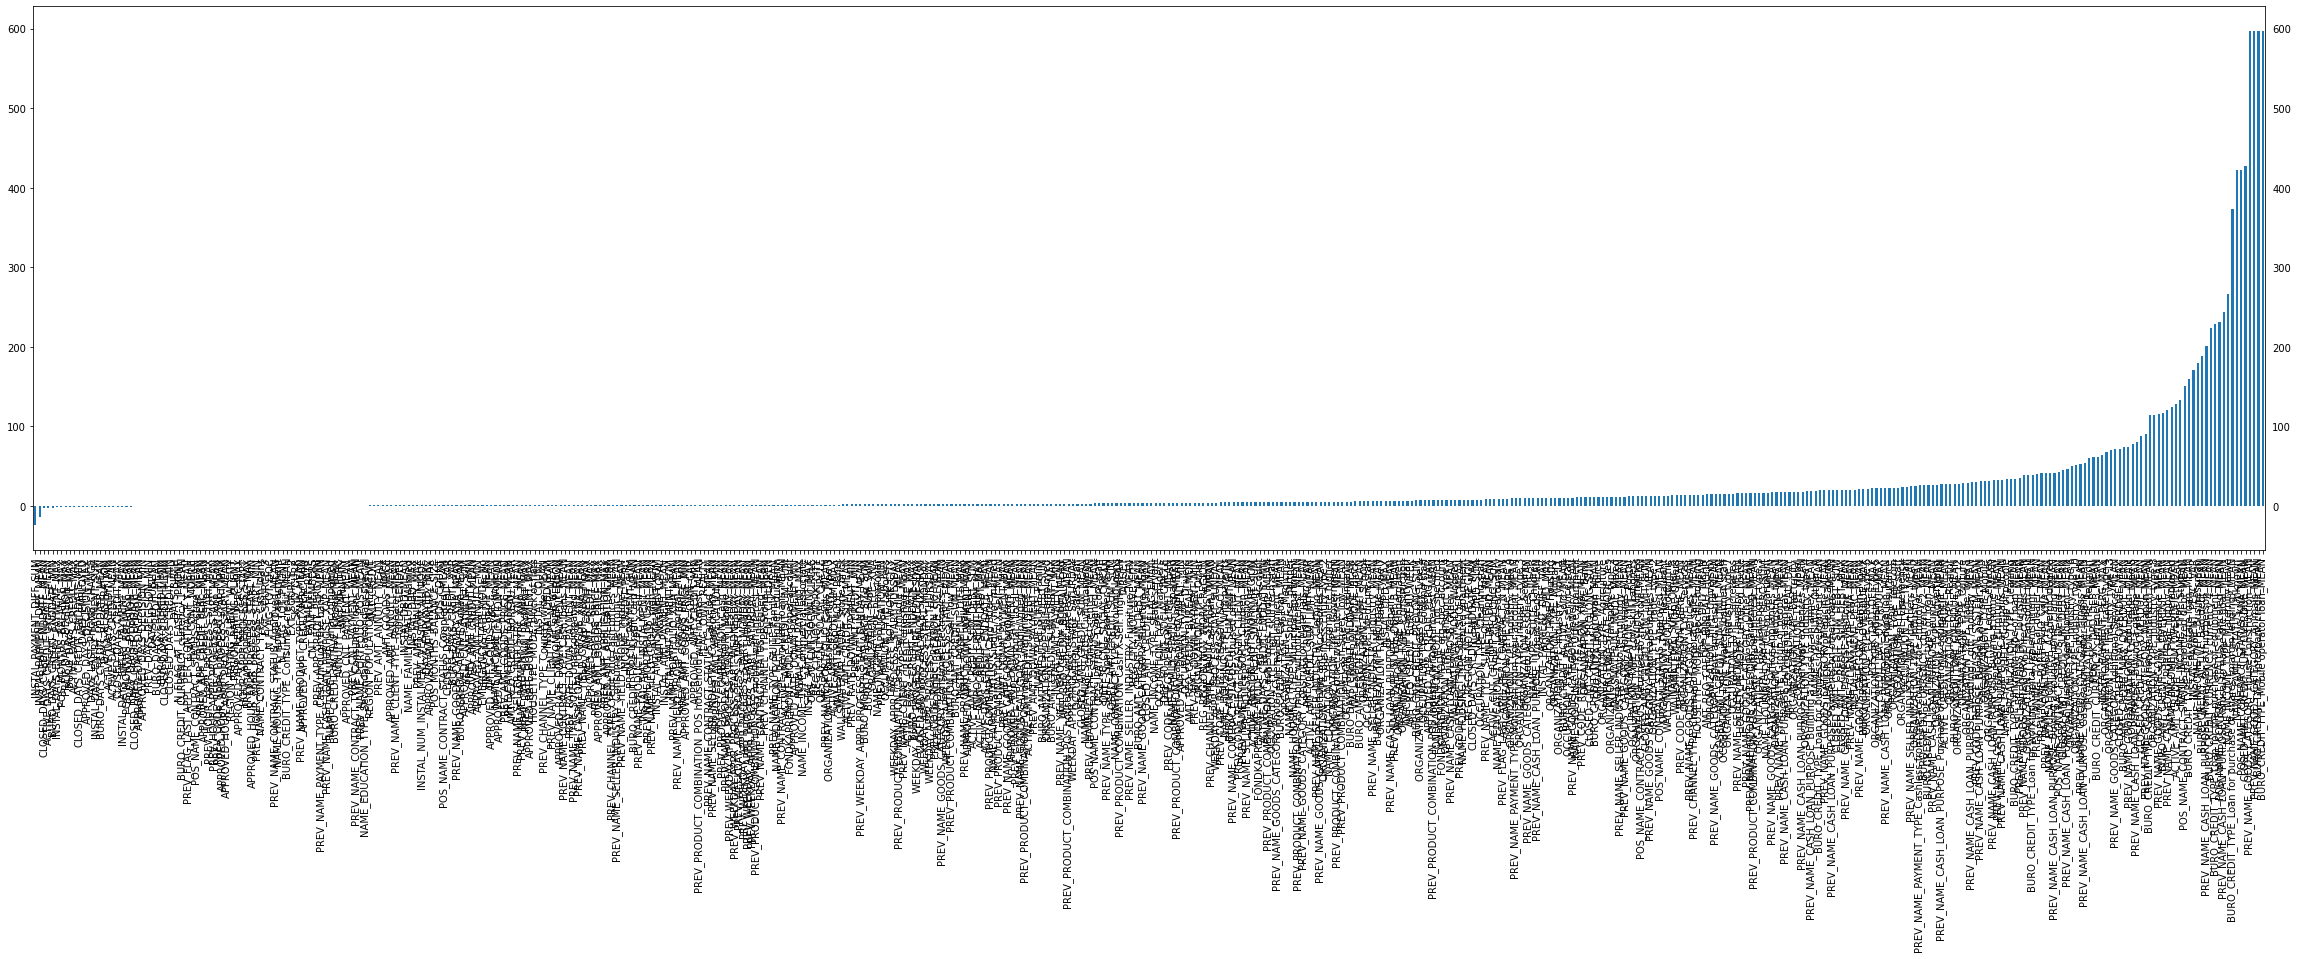

In [92]:
df_coef_var['coef_var'].sort_values().plot(kind='bar',figsize=(40,10));
plt.tick_params(axis='y',labelleft=True,labelright=True)

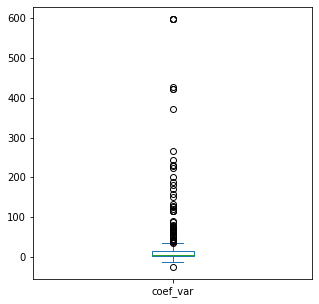

In [19]:
df_coef_var['coef_var'].plot.box(figsize=(5,5));

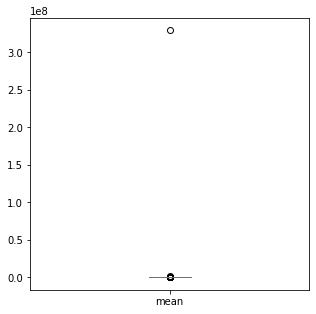

In [20]:
df_coef_var['mean'].plot.box(figsize=(5,5));

#### Calcul de la sélection des Features de variance non nulles (CV >=0.1) et non grandes (CV >=30)

In [21]:
l_sel_col = df_coef_var[(abs(df_coef_var['coef_var']) >= 1e-01) & (abs(df_coef_var['coef_var']) <= 30)].index.tolist()
l_sel_col.remove('index')
l_sel_col.remove('SK_ID_CURR')
len(l_sel_col)

440

## Modélisation 

### Décomposition du Dataset et Standardisation

#### Décomposition du Dataset en X et Xf_test

X correspond au dataset sur laquelle la TARGET est défini : il sera utilisé pour l'apprentissage de la modélisation

Xf_test correspond au dataset sur laquelle la TARGET est défini. Il pourra etre utilisé pour le calcul de score

In [22]:
X = pd.DataFrame()
X = df[df.TARGET.notnull()]
X = X[l_sel_col]
y = X['TARGET']

X = X.drop(['TARGET'], axis=1)

Xf_test = df[df.TARGET.isnull()]
Xf_test = Xf_test[l_sel_col]
Xf_test = Xf_test.drop(['TARGET'], axis=1)

print('X       ',X.shape)
print('Xf_test ',Xf_test.shape)

X        (307507, 439)
Xf_test  (48744, 439)


#### Décomposition du Dataset X et Test,Train suivante un rapport 80/20

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=6)

In [24]:
X_train.shape

(246005, 439)

#### Standardisation du Dataset

Suppose you're working with code like the following.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### X is features, y is label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

When you call StandardScaler.fit(X_train), what it does is calculate the mean and variance from the values in X_train. Then calling .transform() will transform all of the features by subtracting the mean and dividing by the variance. For convenience, these two function calls can be done in one step using fit_transform().

The reason you want to fit the scaler using only the training data is because you don't want to bias your model with information from the test data.

If you fit() to your test data, you'd compute a new mean and variance for each feature. In theory these values may be very similar if your test and train sets have the same distribution, but in practice this is typically not the case.

Instead, you want to only transform the test data by using the parameters computed on the training data.

In [26]:
std_scaler = StandardScaler()

Xs_train=std_scaler.fit_transform(X_train)
Xs_test=std_scaler.transform(X_test)

In [162]:
Xs_test.shape

(61502, 439)

#### Calcul d'un sous-echantillon (subsampling) pour modélisation

On prend un échantillon de taille 0.05%

In [159]:
y_train=y_train.reset_index(drop=True)

y_train_idx_classe_0=y_train[y_train==0].sample(frac=0.05, replace=False, random_state=1).index
y_train_idx_classe_1=y_train[y_train==1].sample(frac=0.05, replace=False, random_state=1).index

y_train_sub=y_train[y_train_idx_classe_0.append(y_train_idx_classe_1)]

Xs_train_sub=Xs_train[y_train_idx_classe_0.append(y_train_idx_classe_1)]

print('Xs_train_sub.shape',Xs_train_sub.shape)
print('y_train_sub.shape ',y_train_sub.shape)

Xs_train_sub.shape (12301, 439)
y_train_sub.shape  (12301,)


### Rééchantillonnage SMOTE par Oversampling

Il est nécessaire avant d'utliser un modèle de classification de commencer par calculer si le dataset possède un déséquilibre (imbalance) de la target à modéliser.

Si oui alors pour réduire cet imbalance du Dataset on peut utliser les techniques suivantes :

- Undersampling : Taille Dataset Grande >= 10000, 100000 points
- Over-sampling  : Taille Dataset Petite < 10000 points
- Combinaison des 2  : Undersampling et Oversampling
- Schemas de smapling random and non-random (stratified par ex.)
- différents ratios de resampling (ex. si l'on a pas un ratio 1:1 dans 1 probleme de classification binaire)
                                
On va utiliser le schéma d'oversampling via SMOTE que l'on intégrera dans le GridSearch pour l'optimisation
des hyperparamètres

#### Calcul de l'imbalance du dataset

In [30]:
print("Target Imbalance %\n", round(y.value_counts()/len(y) * 100),2)

Target Imbalance %
 0.0    92.0
1.0     8.0
Name: TARGET, dtype: float64 2


### Dummy Classifier / Baseline

In [36]:
#“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, 
clf_dummy = DummyClassifier(strategy="most_frequent",random_state=42) 
#establishing random_state for reproducibility
clf_dummy.fit(Xs_train, y_train)
y_pred = clf_dummy.predict(Xs_test)

f1_score=fbeta_score(y_test,y_pred,beta=1)
print('f1_score :',round(f1_score,3))

f2_score=fbeta_score(y_test,y_pred,beta=2)
print('f2_score :',round(f2_score,3))

TN, FP, FN, TP = confusion_matrix(y_test,y_pred).ravel()
print('TN',TN)
print('FP',FP)
print('FN',FN)
print('TP',TP)
print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

acc_score=accuracy_score(y_test,y_pred)
print('accuracy_score :',round(acc_score,3))

AUCROC=roc_auc_score(y_test, clf_dummy.predict_proba(Xs_test)[:,1])
print('AUC : {}'.format(AUCROC))

f1_score : 0.0
f2_score : 0.0
TN 56590
FP 0
FN 4912
TP 0
Precision : nan
Recall    : 0.0
accuracy_score : 0.92
AUC : 0.5


/var/folders/cz/lfz3yqyx0_d2448tqclsnqkm0000gn/T/ipykernel_1500/3281029332.py:18: RuntimeWarning: invalid value encountered in long_scalars
  print('Precision :' , round(TP / (TP + FP),2))


### Métriques

#### Fonctions de Scoring

Matrice de Confusion :

|                | Positive Prediction | Negative Prediction |
|----------------|------|------|
| Positive Class |   TP | FN   |
| Negative Class |   FP |  TN  |

avec :
 - TP : True Positif
 - TN : True Négatif
 - FP : Faux Positif
 - TN : Faux Négatif
 
On a la correpondance suivante avec les Targets (TP,TN) :
- TARGET=0 : Classe minoritaire Negative (TN) : Client Non en défault de paiement
- TARGET=1 : Classe majoritaire Positive (TP) : Client en Défault de paiement


On a 2 Types de Prédiction erronéees :
- Un Faux Négatif (FN) = prédiction d'un Négatif alors qu'il est Positif (Erreur de type 2): On prédit 1 client qui n'est pas en Défault de paiement alors qu'il l'est.
- Un Faux Positif (FP) = prédiction d'un Positif alors qu'il est Négatif (Erreur de type 1): On prédit 1 client qui est en Défault de paiement alors qu'il ne l'est pas.


- L'erreur de type 2 correspond à 1 perte financière
- L'erreur de type 1 correspond à 1 perte de client

On cherchera à minimiser l'erreur de type 2 (FN) par rapport à l'erreur de type 1 (FP) car on prend l'hypothèse d'une perte financières est plus coûteuse qu'un perte de client.

En terme de mesure de classification on utilise les 2 métriques suivantes :
-  $ Recall = \frac{ TP }{ TP + FN } $ Le Recall (ou Sensitivity ou True Positive Rate (TPR)) mesure la capacité du modèle à détecter les samples positifs. C'est la probabilité d'obtenir 1 Positif
- $ Precision = \frac{TP }{ TP + FP } $ La précision mesure l'accuracy à classifier 1 sample comme positive.  C'est la probabilité d'obtenir 1 True Positif

Il s'agit alors de maximiser le Recall et la Precision. Néanmoins puique l'on considère davantage l'erreur de perte financière il est plus important d'optimiser le recall que la précision.
On utilisera alors une combinaison linéaire pondérée de FN et FP qui accordera plus de poids aux FN.

La métrique F-beta score qui est la moyenne harmonique pondérée de la precision et du recall sera utilisée pour cela. Sa valeur optimale est de 1 et sa valeur minimale de 0.
 
 $ F{\beta} = \frac{(1+{\beta}²).Precision.Recall}{ ({\beta}².Precision) + Recall} $ avec $ {\beta} € [0,1] $
 
 $ F{\beta} = \frac{ (1+{\beta}²)×TP } {((1+{\beta}²)×TP + {\beta}²×FN + FP)} $

C'est le coefficient β qui détermine le poids du recall : beta < 1 donne plus de poids à la précision tandis que beta > 1 favorise le recall.
 
Avec β=2 le recall sera deux plus fois important que la précision.

On cherchera donc la valeur F2 maximale :
 
 $ F2 = \frac{ 5.TP }{ (5.TP + 4FN + FP)} $

#### Métriques choisies
- F2 Score
- F1 Score = $ \frac{ (2.Precision.Recall) } {(Precision + Recall)} $
$ = \frac{ 2.TP } {5.TP + 4FN + FP}$
- Precision & Recall
- Accuracy $ = \frac{ TP + TN  } {TP + TN + FP + FN}$
- ROC Curve & AUC

Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial

Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.

F1 score is balancing precision and recall on the positive class while accuracy looks at correctly classified observations both positive and negative.

F1-score: This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric. We use the Harmonic Mean since it penalizes the extreme values.

F1-score compare les prédictions positives correctes (TP) aux erreurs (FN+FP) faites par le modèle.
Un F1-score de 50% équivaut à TP = ½ (FN + FP) et s’interprète donc de la façon suivante : pour une prédiction positive correcte, le modèle fait deux erreurs (faux négatif ou faux positif).
Le F1-score appartient à la famille plus large des F-beta scores. Dans le cas du F1-score, les erreurs (FN+FP) faites par le modèle sont pondérées par un facteur 1⁄2. Le F1-score accorde ainsi la même importance à la precision et au recall, et donc aux faux positifs et aux faux négatifs

That is, a good F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1, while the model is a total failure when it's 0.

In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.

#### Fonction F2 Score

In [32]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

### Régression Logistique

#### Fit pour recherche des hyperparamètres optimaux

In [33]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=3, random_state=42, shuffle=True)

params = {'penalty':['l1','l2'],'C':[0.001, 0.005, 0.01,0.1,0.25,0.5,1]}

new_params = { 'logisticregression__' + key: params[key] for key in params }
imba_pipeline = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42), 
                              LogisticRegression(solver='saga',max_iter =1000,tol=1e-3))
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, n_jobs=-1,cv=kf, scoring=ftwo_scorer,
                         return_train_score=True)
gi_lr=grid_imba.fit(Xs_train_sub, y_train_sub);

#### F2 Score & Best Parameters

In [18]:
cv_score = gi_lr.best_score_
test_score = gi_lr.score(Xs_test, y_test)

print(f'Train (Cross-validation) score: {cv_score}\nTest score: {test_score}')
print('')
print(gi_lr.best_params_)

Train (Cross-validation) score: 0.39117216804645255
Test score: 0.3954148017070886

{'logisticregression__C': 0.005, 'logisticregression__penalty': 'l1'}


#### Matrice de confusion

In [36]:
confusion_matrix(y_test,gi_lr.predict(Xs_test))

array([[40849, 15741],
       [ 1873,  3039]])

In [182]:
TN, FP, FN, TP = confusion_matrix(y_test,gi_lr.predict(Xs_test)).ravel()

print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

Precision : 0.16
Recall    : 0.62


 #### Rapport de Classification

In [40]:
print(classification_report(y_test, gi_lr.predict(Xs_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     56590
         1.0       0.16      0.62      0.26      4912

    accuracy                           0.71     61502
   macro avg       0.56      0.67      0.54     61502
weighted avg       0.89      0.71      0.78     61502



Le modèle a détecté 62% de clients en défaut de paiement

Seulement 16% sont correctements classifiés comne réellement en défaut de paiement

Le F1 Score de 0.26 est faible et donc mauvais.

L'accuracy est "assez bonne" avec 0.71.

Support: These values simply tell us how many players belonged to each class in the test dataset.

##### ROC Curve AUC

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

False Positive Rate (FPR), or “Fall-Out”, is the proportion of negative cases incorrectly identified as positive cases in the data, i.e. the probability that false alerts will be raised or false alarm rate.

FPR = FP / (FP + TN)

FPR = 1 - Specificity

Specificity = TN / (TN + FP). Specificity is the ability of a test to correctly identify people without default payment.

TPR = TP / TP + FN (True Positive Rate (TPR) Recall ou Sensitivity)

Logistic Reg: ROC AUC=0.731


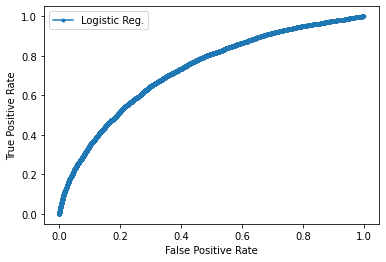

In [41]:
# generate prediction 
lr_probs = gi_lr.predict_proba(Xs_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression:')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### RandomForest Classifier

In [3]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5,random_state=42,shuffle=True)

params = { 'n_estimators':[32,64],'max_depth':[32,64], 'max_samples':[0.1,0.5,1],
           'min_samples_split': [5,10,15], 'max_features': ['sqrt','log2'],'min_samples_leaf': [5,10,15]}
#params = { 'n_estimators':[512],'max_depth':[512] 'max_features': [0.01,0.02,0.05]}

new_params = { 'randomforestclassifier__' + key: params[key] for key in params }

imba_pipeline = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42), 
                              RandomForestClassifier())

grid_imba_rf = GridSearchCV(imba_pipeline,param_grid=new_params,n_jobs=-1,cv=kf,scoring=ftwo_scorer,
                            return_train_score=True)

gi_rf=grid_imba_rf.fit(Xs_train_sub, y_train_sub);

#### F2 Score & Best Parameters

In [19]:
cv_score_rf = gi_rf.best_score_
test_score_rf  = fbeta_score(y_test,gi_rf.predict(Xs_test),beta=2)

print(f'Train (Cross-validation) score: {cv_score_rf}\nTest score: {test_score_rf}')
print('')
print(gi_rf.best_params_)

Train (Cross-validation) score: 0.30542886629248633
Test score: 0.3026494146642021

{'randomforestclassifier__max_depth': 64, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_samples': 1, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__n_estimators': 64}


#### Matrice de confusion

In [6]:
TN, FP, FN, TP = confusion_matrix(y_test,gi_rf.predict(Xs_test)).ravel()
print('TN',TN)
print('FP',FP)
print('FN',FN)
print('TP',TP)

print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

TN 0
FP 56590
FN 0
TP 4912
Precision : 0.08
Recall    : 1.0


#### Rapport de Classification

In [7]:
print(classification_report(y_test, gi_rf.predict(Xs_test)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     56590
         1.0       0.08      1.00      0.15      4912

    accuracy                           0.08     61502
   macro avg       0.04      0.50      0.07     61502
weighted avg       0.01      0.08      0.01     61502



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

##### ROC Curve AUC

In [8]:
# generate prediction
lr_probs = gi_rf.predict_proba(Xs_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

Random Forest: ROC AUC=0.500


### XGB

XGB

Most common tuning parameters that XGBoost provides :
- Learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
-colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for 
  classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models :

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. 
  A higher value leads to fewer splits. Supported only for tree-based learners. In contrast with min_child_weight and max_depth that regularise using "within tree" information, gamma works by regularising using "across trees" information. In particular by observing what is the typical size of loss changes we can adjust gamma appropriately such that we instruct our trees to add nodes only if the associated gain is larger or equal to 𝛾.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.



In [45]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5,random_state=42, shuffle=True)

params = { 'learning_rate':[0.1],'objective':['binary:logistic'],'subsample':[0.2,0.3,0.4],
           'n_estimators':[2,3], 'gamma': [0,5],'max_depth':[2,3],'colsample_bytree':[0.4,0.5,0.6] }

new_params = { 'xgbclassifier__' + key: params[key] for key in params }

imba_pipeline = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42),xgb.XGBClassifier())

grid_imba_xgb = GridSearchCV(imba_pipeline,param_grid=new_params,n_jobs=-1,cv=kf,scoring=ftwo_scorer,
                            return_train_score=True)

gi_xgb=grid_imba_xgb.fit(Xs_train_sub, y_train_sub);

#### F2 Score & Best Parameters

In [20]:
cv_score_xgb = gi_xgb.best_score_
test_score_xgb  = fbeta_score(y_test,gi_xgb.predict(Xs_test),beta=2)

print(f'Train (Cross-validation) score: {cv_score_xgb}\nTest score: {test_score_xgb}')
print('')
print(gi_xgb.best_params_)

Train (Cross-validation) score: 0.3208461934489969
Test score: 0.3250599351290368

{'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 2, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__subsample': 0.3}


#### Matrice de confusion

In [10]:
TN, FP, FN, TP = confusion_matrix(y_test,gi_xgb.predict(Xs_test)).ravel()
print('TN',TN)
print('FP',FP)
print('FN',FN)
print('TP',TP)

print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

TN 36458
FP 20132
FN 2146
TP 2766
Precision : 0.12
Recall    : 0.56


#### Rapport de Classification

In [11]:
print(classification_report(y_test, gi_xgb.predict(Xs_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.64      0.77     56590
         1.0       0.12      0.56      0.20      4912

    accuracy                           0.64     61502
   macro avg       0.53      0.60      0.48     61502
weighted avg       0.88      0.64      0.72     61502



#### ROC Curve AUC

In [12]:
# generate prediction
lr_probs = gi_xgb.predict_proba(Xs_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('XGB: ROC AUC=%.3f' % (lr_auc))

XGB: ROC AUC=0.631


#### Augmentation de la taille du Dataset => 0.7%

In [13]:
y_train_idx_classe_0_s=y_train[y_train==0].sample(frac=0.7, replace=False, random_state=1).index
y_train_idx_classe_1_s=y_train[y_train==1].sample(frac=0.7, replace=False, random_state=1).index

print(len(y_train_idx_classe_0_s))
print(len(y_train_idx_classe_1_s))

y_train_sub_s=y_train[y_train_idx_classe_0_s.append(y_train_idx_classe_1_s)]

Xs_train_sub_s=Xs_train[y_train_idx_classe_0_s.append(y_train_idx_classe_1_s)]

print('Xs_train_sub_s.shape',Xs_train_sub_s.shape)
print('y_train_sub_s.shape',y_train_sub_s.shape)

158264
13939
Xs_train_sub_s.shape (172203, 439)
y_train_sub_s.shape (172203,)


#### Prédiction avec les hyperparamètres obtenus sur l'échantillon de taille 0.05%

In [66]:
# Create prédiction and get score
train_score_xgb_s = fbeta_score(y_train_sub_s,gi_xgb.predict(Xs_train_sub_s),beta=2)
test_score_xgb_s = fbeta_score(y_test,gi_xgb.predict(Xs_test),beta=2)

print("train_score :", round(train_score_xgb_s,3))
print("train_score :", round(test_score_xgb_s,3))

train_score : 0.33
train_score : 0.325


#### Re-Fit et Prédiction sur l'échantillon de taille 0.7%

In [67]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5,random_state=42,shuffle=True)

params = { 'learning_rate':[0.1],'objective':['binary:logistic'],'subsample':[0.4,0.5,0.6],
           'n_estimators':[2], 'gamma': [0],'max_depth':[2],'colsample_bytree':[0.4,0.5,0.6] }

new_params = { 'xgbclassifier__' + key: params[key] for key in params }

imba_pipeline = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42), 
                               xgb.XGBClassifier())

grid_imba_xgb = GridSearchCV(imba_pipeline,param_grid=new_params,n_jobs=-1,cv=kf,scoring=ftwo_scorer,
                             return_train_score=True)

gi_xgb_s=grid_imba_xgb.fit(Xs_train_sub_s, y_train_sub_s);

#### F2 Score & Best Parameters

In [21]:
cv_score_xgb = gi_xgb_s.best_score_
test_score_xgb = gi_xgb_s.score(Xs_test, y_test)

print(f'Train (Cross-validation) score: {cv_score_xgb}\nTest score: {test_score_xgb}')
print('')
print(gi_xgb_s.best_params_)

Train (Cross-validation) score: 0.3168088775777683
Test score: 0.3334438549955791

{'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 2, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__subsample': 0.4}


#### Matrice de Confusion

In [22]:
TN, FP, FN, TP = confusion_matrix(y_test,gi_xgb.predict(Xs_test)).ravel()
print('TN',TN)
print('FP',FP)
print('FN',FN)
print('TP',TP)

print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

TN 36458
FP 20132
FN 2146
TP 2766
Precision : 0.12
Recall    : 0.56


#### Rapport de Classification

In [24]:
print(classification_report(y_test, gi_xgb.predict(Xs_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.64      0.77     56590
         1.0       0.12      0.56      0.20      4912

    accuracy                           0.64     61502
   macro avg       0.53      0.60      0.48     61502
weighted avg       0.88      0.64      0.72     61502



#### ROC Curve AUC

In [25]:
# generate prediction
lr_probs = gi_xgb.predict_proba(Xs_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('XGB: ROC AUC=%.3f' % (lr_auc))

XGB: ROC AUC=0.631


## Optimisation du Best Model

Le meilleur modèle est le modèle de régression logistique

### Augmentation de la taille du Dataset -> 0.7

#### Prédiction avec les hyperparamètres obtenus sur l'échantillon de taille 0.05%

In [70]:
cv_score = gi_lr.best_score_
test_score = gi_lr.score(Xs_test, y_test)

print(f'Train (Cross-validation) score: {cv_score}\nTest score: {test_score}')

Train (Cross-validation) score: 0.39117216804645255
Test score: 0.3954148017070886


##### Re-Fit et Prédiction sur l'échantillon de taille 0.7%

In [75]:
Xs_train_sub_s.shape

(172203, 439)

In [76]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=3, random_state=42, shuffle=True)

params_opt = {'penalty':['l1'],'C':[0.003, 0.005]}

new_params_opt = { 'logisticregression__' + key: params_opt[key] for key in params_opt }
imba_pipeline_opt = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42), 
                                        LogisticRegression(solver='saga',max_iter =1000,tol=1e-3))
grid_imba_opt = GridSearchCV(imba_pipeline_opt, param_grid=new_params_opt, n_jobs=-1,cv=kf, scoring=ftwo_scorer,
                             return_train_score=True)
gi_lr_opt=grid_imba_opt.fit(Xs_train_sub_s, y_train_sub_s);

#### F2 Score & Best Parameters

In [26]:
cv_score = gi_lr_opt.best_score_
test_score = gi_lr_opt.score(Xs_test, y_test)

print(f'Train (Cross-validation) score: {cv_score}\nTest score: {test_score}')
print('')
print(c.best_params_)

Train (Cross-validation) score: 0.4112511607119993
Test score: 0.4096781650527829

{'logisticregression__C': 0.003, 'logisticregression__penalty': 'l1'}


#### Matrice de Confusion

In [29]:
TN, FP, FN, TP = confusion_matrix(y_test,gi_lr_opt.predict(Xs_test)).ravel()
print('TN',TN)
print('FP',FP)
print('FN',FN)
print('TP',TP)

print('Precision :' , round(TP / (TP + FP),2))
print('Recall    :' , round(TP / (TP + FN),2))

TN 40495
FP 16095
FN 1722
TP 3190
Precision : 0.17
Recall    : 0.65


#### Rapport de Classification

In [28]:
print(classification_report(y_test, gi_lr_opt.predict(Xs_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     56590
         1.0       0.17      0.65      0.26      4912

    accuracy                           0.71     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.90      0.71      0.78     61502



#### ROC Curve AUC

Logistic Regression: ROC AUC=0.749


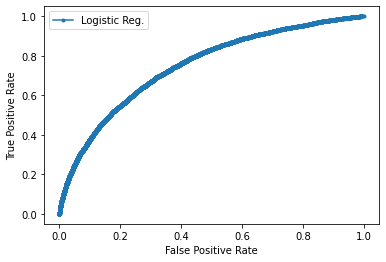

In [50]:
# generate predictions
lr_probs = gi_lr_opt.predict_proba(Xs_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Reg.')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

## Interprétabilité du Modèle

L’interprétabilité propose une évaluation globale d’un processus de décision alors que l’explicabilité s’intéresse aux variables qui ont été déterminantes pour une décision particulière. Dans le cadre de l’évaluation d’un modèle de machine learning on parle généralement d’interprétabilité car on établit une représentation (possiblement visuelle) de l’importance des variables qui mènent à ses prédictions. Si l’on veut comprendre une prédiction donnée, alors on cherche son explication.


### Interprétabilité Globale - Permutation Importance

In [80]:
from sklearn.inspection import permutation_importance

results = permutation_importance(gi_lr_opt,
                                 Xs_train,
                                 y_train,
                                 scoring=ftwo_scorer,
                                 n_repeats=1,
                                 max_samples=1.0)

results

{'importances_mean': array([ 3.95969488e-05,  5.93797479e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.79975364e-04,
         3.97023350e-05,  0.00000000e+00,  1.32171353e-04,  7.24461800e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.93005699e-04,
         0.00000000e+00,  3.44420057e-04,  5.28665275e-05,  0.00000000e+00,
         0.00000000e+00,  2.35177110e-04,  1.50841447e-04,  3.84372974e-04,
         6.37922192e-05,  2.82368428e-05,  0.00000000e+00,  0.00000000e+00,
         6.39992305e-05,  3.09331617e-03,  8.23630132e-05,  2.13490180e-04,
         3.66260683e-05,  0.00000000e+00,  3.98077052e-05,  1.37576073e-04,
         4.64484980e-04,  1.03484269e-04,  0.00000000e+00,  0.00000000e+00,
         4.33525442e-02,  1.94441085e-03,  2.27045822e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.10045994e-04,
         0.00000000e+00,  9.37837202e-04,  1.11598242e-04, -1.592520

Text(0.5, 1.0, 'Feature Importance')

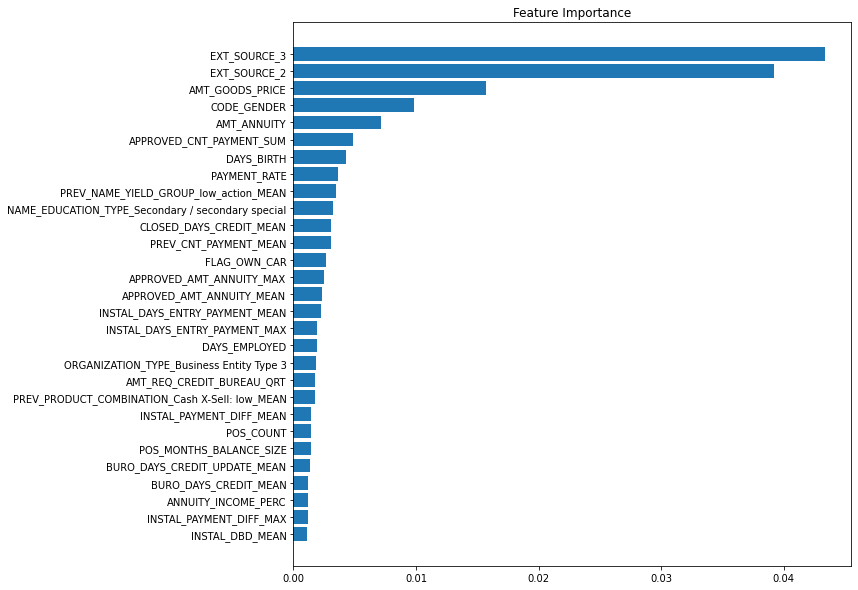

In [82]:
fig = plt.figure(figsize=(10, 10))

sorted_idx = np.argsort(results['importances_mean'])[:-30:-1]
plt.barh(range(len(sorted_idx)), results['importances_mean'][sorted_idx][:-30:-1], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx][:-30:-1])
plt.title('Feature Importance')

### Interprétabilité Locale avec Lime

https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe
https://arxiv.org/pdf/2004.12277.pdf

An explainable model with good interpretability should be faithful to the original model, understandable to the observer, and graspable in a short time so that the end-user can make wise decisions. Local explanation method learns a model from a set of data samples which is sampled around the instance being explained. The dissimilarity between the true label and predicted label is defined as the loss function L(f (x), g(x)) which is a measure of how unfaithful g(x) is in approximating f(x). In order to ensure both local fidelity and understandability, we add regularization term to loss function:
J(θ) = argminL(f(x), gθ(x)) + λΩ(θ). (1)
The regularisation term is a measure of complexity of the explainable model g(x). The smaller the regularisation term is, the better the sparsity of model g(x), which leads to better understandability.

The output of LIME is a list of explanations, reflecting the contribution of each feature to the prediction of a data sample. This provides local interpretability, and it also allows to determine which feature changes will have most impact on the prediction.

LIME Algorithm

- Choose the ML model and a reference point to be explained
- Generate points all over the ℝᵖ space 
(sample X values from a Normal distribution inferred from the training set)
- Predict the Y coordinate of the sampled points, using the ML model 
(the generated points are guaranteed to perfectly lie on the ML surface)
- Assign weights based on the closeness to the chosen point 
(use RBF Kernel, it assigns higher weights to points closer to the reference)
- Train Linear Ridge Regression on the generated weighted dataset: 
E(Y)= β₀ + ∑ βⱼ Xⱼ. The β coefficients are regarded as LIME explanation.

The recipe for training local surrogate models:
- Select your instance of interest for which you want to have an explanation of its black box prediction.
- Perturb your dataset and get the black box predictions for these new points.
- Weight the new samples according to their proximity to the instance of interest.
- Train a weighted, interpretable model on the dataset with the variations.
- Explain the prediction by interpreting the local model.

How LIME Works
For a given observation :
- 1.Permute data -Create new dataset around observation by sampling from distribution learnt on training data (In the Perturbed dataset for Numerical features are picked based on the distribution & categorical values based on the occurrence)
- 2.Calculate distance between permutations and original observations
- 3.Use model to predict probability on new points, that’s our new y
- 4.Pick m features best describing the complex model outcome from the permuted data
- 5.Fit a linear model on data in m dimensions weighted by similarity
- 6.Weights of linear model are used as explanation of decision

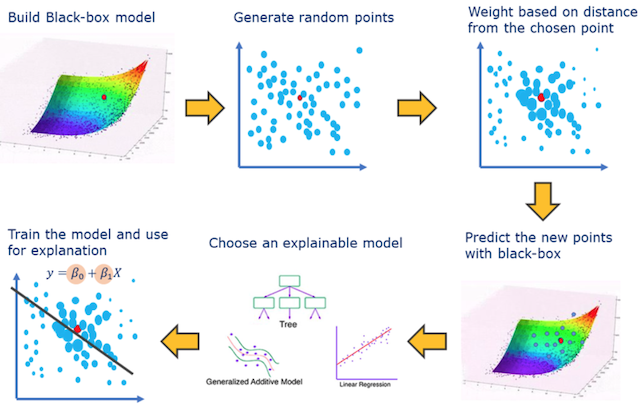

When using LIME to explain an instance 𝑖, we create fake data because through them and their subsequent labelling we can infer how our complex learner 𝐿 would behave in neighbourhood of 𝑖
through a simpler learner. (See comment in the end.) What you describe about taking the actual data is perfectly reasonable given that the reasonable neighbours exist and we can "look around" the instance 𝑖. If an instance 𝑖 does not have close neighbours it become difficult to explain why a particular result was obtain because we lack a comparable sample. The perturbation (in theory) ensures that we have a reasonable chance of creating close neighbours and thus investigate 𝐿's behaviour on them.

Regarding on how the similarity score is used and what we model exactly: The similarity score is used as a weight. Observations that are close (in terms of similarity score) to the instance 𝑖 are given higher weight, i.e. we are saying to the simple/explainer model 𝑆 to treat these (artificial) points as more significant.To that extent, given that usually we use some kind of penalised regression (e.g. LASSO) for our explainer 𝑆
we readily get the "𝑚 more explanatory" variables. Also, as standard regression procedures can be easily extended to weighted regression routines we thus get a straightforward methodology! To be clear: the outcome that we model with 𝑆 is the artificial labels we assigned to the "fake data" through our learner 𝐿.

Finally, in regards to using a very long (high 𝑁) but relatively thin (small 𝑝) dataset. (i.e. we are in a 𝑁>>𝑝 situation) That is perfectly fine in terms of LIME and suggests that is is more likely that we have to have relevant neighbours when training our original learner 𝐿. Do note that LIME is not strongly affect by the number of available "true" training examples as ultimately the explainer is trained on the "fake data". The learner 𝐿 will indeed benefit from a large (and potentially representative) sample but that is not directly affecting LIME's computation aside the fact that the labelling of the fake data will be (hopefully) more representative.

Drawbacks of LIME :
- Depends on the random sampling of new points, so it can be unstable
- Fit of linear model can be inaccurate


https://vishesh-gupta.medium.com/understanding-your-model-with-lime-d7704d984696

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

Point to Note: LIME takes in numerical data, even if the features are categorical .So you will have to convert the categorical . You can transform all of the string attributes into integers, using sklearn’s LabelEncoder and also use a dict to save the correspondence between the integer values and the original strings, so it can be presented later in the explanations.

Lime doesn’t support OHE because it perturbs the dataset so let’s say we encode the variable “sex” with one hot encoding, such that [1, 0] is male and [0, 1] is female. While, perturbing the dataset , Lime with generate [1, 1] which is a nonsensical input (which will give your model something invalid).For further details you can refer to this thread

There is work around the use of One hot encoding or any other type of transformation .you can follow the steps in this notebook

### Ré-entrainement du Best Model de Regression Logistique en partant des données d'origine

#### Reconstruction des Catégories pour LIME

In [87]:
l_cat_exp_f=[]
l_cat_exp=l_cat_fil.copy()
l_cat_exp.remove('ORGANIZATION_TYPE_Religion')
l_cat_exp.remove('ORGANIZATION_TYPE_Mobile')
l_cat_exp.remove('ORGANIZATION_TYPE_Trade: type 5')
l_cat_exp.remove('NAME_EDUCATION_TYPE_Academic degree')
l_cat_exp.remove('NAME_INCOME_TYPE_Maternity leave')
l_cat_exp.remove('ORGANIZATION_TYPE_Industry: type 8')
l_cat_exp.remove('ORGANIZATION_TYPE_Trade: type 4')
l_cat_exp.remove('NAME_TYPE_SUITE_Group of people')
l_cat_exp.remove('ORGANIZATION_TYPE_Legal Services')
l_cat_exp.remove('ORGANIZATION_TYPE_Industry: type 10')
l_cat_exp.remove('ORGANIZATION_TYPE_Industry: type 13')
l_cat_exp.remove('ORGANIZATION_TYPE_Cleaning')
l_cat_exp.remove('ORGANIZATION_TYPE_Industry: type 6')
l_cat_exp.remove('NAME_INCOME_TYPE_Businessman')
l_cat_exp.remove('ORGANIZATION_TYPE_Transport: type 1')
l_cat_exp.remove('NAME_INCOME_TYPE_Student')
l_cat_exp.remove('NAME_INCOME_TYPE_Unemployed')
#l_cat_exp.remove('ORGANIZATION_TYPE_Industry: type 6')

for c in list(l_cat_exp):
    if 'TYPE' in c:
        if not 'MEAN' in c:
            l_cat_exp_f.append(c)
            print(X_train[c].value_counts())

0.0    244966
1.0      1039
Name: OCCUPATION_TYPE_Secretaries, dtype: int64
0.0    244135
1.0      1870
Name: ORGANIZATION_TYPE_Police, dtype: int64
0.0    237843
1.0      8162
Name: NAME_EDUCATION_TYPE_Incomplete higher, dtype: int64
0.0    244038
1.0      1967
Name: ORGANIZATION_TYPE_Agriculture, dtype: int64
0.0    237569
1.0      8436
Name: ORGANIZATION_TYPE_Business Entity Type 2, dtype: int64
0.0    243427
1.0      2578
Name: ORGANIZATION_TYPE_Security, dtype: int64
0.0    241685
1.0      4320
Name: ORGANIZATION_TYPE_Transport: type 4, dtype: int64
0.0    237069
1.0      8936
Name: ORGANIZATION_TYPE_Medicine, dtype: int64
0.0    245277
1.0       728
Name: ORGANIZATION_TYPE_Industry: type 4, dtype: int64
0.0    242949
1.0      3056
Name: NAME_EDUCATION_TYPE_Lower secondary, dtype: int64
0.0    188710
1.0     57295
Name: NAME_INCOME_TYPE_Commercial associate, dtype: int64
0.0    242304
1.0      3701
Name: OCCUPATION_TYPE_Cleaning staff, dtype: int64
0.0    186238
1.0     59767
Name

In [88]:
XE_train = X_train.copy()
ye_train = y_train.copy()

In [ ]:
#XE_train.reset_index(drop=True, inplace=True)

In [89]:
#tot=0
XE_train['ORGANIZATION_TYPE']='Unknown'
XE_train['NAME_TYPE_SUITE']='Unknown'
XE_train['NAME_HOUSING_TYPE']='Unknown'
XE_train['NAME_TYPE_SUITE']='Unknown'
XE_train['OCCUPATION_TYPE']='Unknown'
XE_train['NAME_EDUCATION_TYPE']='Unknown'
XE_train['NAME_INCOME_TYPE']='Unknown'
XE_train['HOUSETYPE_MODE']='Unknown'   
XE_train['NAME_INCOME_TYPE']='Unknown'
XE_train['HOUSETYPE_MODE']='Unknown'

for c in l_cat_exp_f:
    #print(c)
    if 'ORGANIZATION_TYPE' in c:
        #tot = X_train[c].value_counts()[1] + tot
        val=c[18:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():    
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'ORGANIZATION_TYPE']=val
    elif 'NAME_HOUSING_TYPE' in c:    
        val=c[18:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'NAME_HOUSING_TYPE']=val     
    elif 'NAME_TYPE_SUITE' in c:    
        val=c[16:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'NAME_TYPE_SUITE']=val   
    elif 'OCCUPATION_TYPE' in c:
        val=c[16:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'OCCUPATION_TYPE']=val   
    elif 'NAME_EDUCATION_TYPE' in c:
        val=c[20:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'NAME_EDUCATION_TYPE']=val   
    elif 'NAME_INCOME_TYPE' in c:
        val=c[17:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'NAME_INCOME_TYPE']=val   
    elif 'HOUSETYPE_MODE' in c:
        val=c[15:]
        #for i in range(len(X_train)):
        for i in X_train.index.to_list():  
            if XE_train.loc[i,c]==1:
                XE_train.loc[i,'HOUSETYPE_MODE']=val

In [90]:
print(XE_train['NAME_INCOME_TYPE'].value_counts())
print(XE_train['ORGANIZATION_TYPE'].value_counts())
print(XE_train['NAME_TYPE_SUITE'].value_counts())
print(XE_train['NAME_HOUSING_TYPE'].value_counts())
print(XE_train['NAME_TYPE_SUITE'].value_counts())
print(XE_train['OCCUPATION_TYPE'].value_counts())
print(XE_train['NAME_EDUCATION_TYPE'].value_counts())
print(XE_train['NAME_INCOME_TYPE'].value_counts())
print(XE_train['HOUSETYPE_MODE'].value_counts()) 

Working                 127119
Commercial associate     57295
Pensioner                44243
State servant            17299
Unknown                     49
Name: NAME_INCOME_TYPE, dtype: int64
Business Entity Type 3    54431
XNA                       44254
Self-employed             30807
Other                     13264
Medicine                   8936
Business Entity Type 2     8436
Government                 8362
School                     7092
Trade: type 7              6228
Kindergarten               5457
Construction               5384
Business Entity Type 1     4794
Transport: type 4          4320
Trade: type 3              2820
Industry: type 9           2679
Industry: type 3           2643
Security                   2578
Housing                    2380
Industry: type 11          2197
Military                   2121
Bank                       2018
Agriculture                1967
Police                     1870
Transport: type 2          1782
Postal                     1705
Security

In [91]:
print('XE_train.shape',XE_train.shape)
XE_train=XE_train.drop(columns=l_cat_exp_f,axis=1)
print('XE_train.shape',XE_train.shape)

XE_train.shape (246005, 446)
XE_train.shape (246005, 356)


#### Label Encoding des Features Catégoriques

In [92]:
from sklearn.preprocessing import LabelEncoder

l_cat=['ORGANIZATION_TYPE','NAME_TYPE_SUITE','NAME_HOUSING_TYPE','NAME_TYPE_SUITE','OCCUPATION_TYPE',
       'NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','HOUSETYPE_MODE','NAME_INCOME_TYPE','HOUSETYPE_MODE']
categorical_names = {}
categorical_features=[]

for feature in l_cat:
    categorical_features.append(XE_train.columns.get_loc(feature))

for feature in l_cat:
    le = LabelEncoder()
    le.fit(XE_train[feature])
    XE_train[feature] = le.transform(XE_train[feature])
    categorical_names[feature] = le.classes_

#### Split Train / Test

In [93]:
np.random.seed(1)
train, test, labels_train, labels_test = train_test_split(XE_train, ye_train, train_size=0.80)

#### Sauvegarde pour API Flask

In [143]:
import csv
l=df.loc[train.index]['SK_ID_CURR'].to_csv()
with open('idclient.csv', 'w') as f:
    f.write(l)
    
train.to_pickle("f_train.pkl")

#### One Hot Encoding et Standardisation des Train / Test set

In [95]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
transformer = make_column_transformer( (OneHotEncoder(), categorical_features), remainder="passthrough" )

transformer.fit(train)
encoded_train = transformer.transform(train)

In [96]:
encoded_test=transformer.transform(test)
std_scaler_lime = StandardScaler()

Xl_train=std_scaler_lime.fit_transform(encoded_train)
Xl_test=std_scaler_lime.transform(encoded_test)

In [104]:
with open("f_std_scaler_lime.dat","wb") as f:
    pickle.dump(std_scaler_lime, f)
    f.close()

#### Entraînement du modèle

In [99]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=3, random_state=42, shuffle=True)

params = {'penalty':['l1'],'C':[0.005]}

new_params = { 'logisticregression__' + key: params[key] for key in params }
imba_pipeline_lime = make_pipeline(SMOTE(sampling_strategy='auto',k_neighbors=5,random_state=42), 
                                   LogisticRegression(solver='saga',max_iter =1000,tol=1e-3))
grid_imba_lime = GridSearchCV(imba_pipeline_lime, param_grid=new_params, n_jobs=-1,cv=kf, scoring=ftwo_scorer,
                              return_train_score=True)
gil_lr=grid_imba_lime.fit(Xl_train, labels_train);

In [100]:
cv_score = gil_lr.best_score_
test_score = gil_lr.score(Xl_test, labels_test)

print(f'Train (Cross-validation) score: {cv_score}\nTest score: {test_score}')

Train (Cross-validation) score: 0.40994617566907426
Test score: 0.4238927011852776


#### Sauvegarde pour API Flask

In [105]:
with open('f_gil_lr.pkl', 'wb') as f:
    pickle.dump(gil_lr, f)
f.close()

with open('f_transformer.pkl', 'wb') as f:
    pickle.dump(transformer, f)
f.close()

#### Interprétabilité Globale - Regression logistique

In [134]:
def new_attribute(x):
    
    len_pref_1=len('onehotencoder__')
    len_pref_2=len('remainder__')
    
    if 'onehotencoder' in x:
         new_x=x[len_pref_1:len(x)]
    elif 'remainder' in x:
        new_x=x[len_pref_2:len(x)]
   
    return new_x

In [66]:
from matplotlib.pyplot import figure

figure(figsize=(4, 6), dpi=80)

l_coef=gil_lr.best_estimator_.named_steps['logisticregression'].coef_[0]

df_feat_imp=pd.DataFrame(data={'Attribute': transformer.get_feature_names_out(), 'Importance': l_coef})
df_feat_imp['Attribute']=df_feat_imp['Attribute'].map(new_attribute)

df_feat_imp_s = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp_s.iloc[:20]

Attribute  Importance
425                      AMT_CREDIT    0.382553
233        APPROVED_CNT_PAYMENT_SUM    0.273835
177    BURO_DAYS_CREDIT_UPDATE_MEAN    0.239007
405                     AMT_ANNUITY    0.208340
151                   DAYS_EMPLOYED    0.176128
5               ORGANIZATION_TYPE_5    0.166413
90            NAME_EDUCATION_TYPE_3    0.163184
125       ACTIVE_AMT_CREDIT_SUM_SUM    0.162760
379  INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.144224
384        INSTAL_PAYMENT_DIFF_MEAN    0.143643
34             ORGANIZATION_TYPE_34    0.124855
240           PREV_CNT_PAYMENT_MEAN    0.120534
423                      DAYS_BIRTH    0.118631
391                  INSTAL_DBD_MAX    0.107476
378         INSTAL_PAYMENT_DIFF_MAX    0.102572
418     REGION_RATING_CLIENT_W_CITY    0.086864
421                 DAYS_ID_PUBLISH    0.079373
435                  N_FLAG_TOT_DOC    0.079057
76                OCCUPATION_TYPE_8    0.074065
280             PREV_AMT_CREDIT_MAX    0.073591

<Figure size 320x480 with 0 Axes>

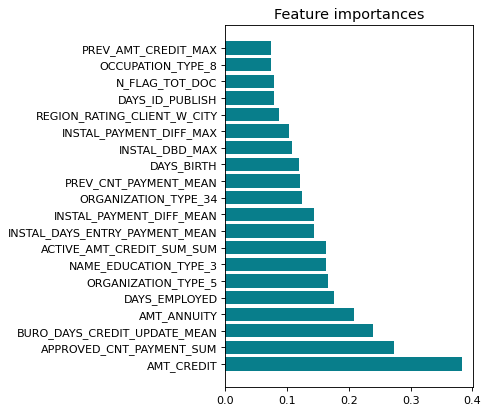

In [69]:
from matplotlib.pyplot import figure

figure(figsize=(4, 6), dpi=80)

l_coef=gil_lr.best_estimator_.named_steps['logisticregression'].coef_[0]

df_feat_imp=pd.DataFrame(data={'Attribute': transformer.get_feature_names_out(), 'Importance': l_coef})
df_feat_imp['Attribute']=df_feat_imp['Attribute'].map(new_attribute)

df_feat_imp_s = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp_20=df_feat_imp_s.iloc[:20]

plt.barh(y=df_feat_imp_20['Attribute'], width=df_feat_imp_20['Importance'], color='#087E8B')
plt.title('Feature importances', size=13)
#plt.xticks(rotation='vertical')
plt.show()

In [140]:
with open("f_feature_imp_lr.dat","wb") as f:
    pickle.dump(df_feat_imp_20, f)
    f.close() 

#### Lime Explainer

In [141]:
predict_fn = lambda x: gil_lr.predict_proba(std_scaler_lime.transform(transformer.transform(x))).astype(float)

In [142]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = train.values,
                                                   feature_names = train.columns,
                                                   training_labels = labels_train,
                                                   class_names=['Non Default','Default'],
                                                   discretizer='decile',
                                                   discretize_continuous=True,
                                                   verbose=1,
                                                   random_state=20,
                                                   mode='classification',
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, 
                                                   kernel_width=5)

#### Sauvegarde pour l'API Flask

In [48]:
with open('f_explainer.dat', 'wb') as f:
    dill.dump(explainer, f)

#### Lime Explaining predictions

In [46]:
exp = explainer.explain_instance(train.values[1],predict_fn,num_features=20,top_labels=1)

exp.show_in_notebook(show_table=True, show_all=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Intercept 0.08232107392363497
Prediction_local [0.48583097]
Right: 0.5395062193732412


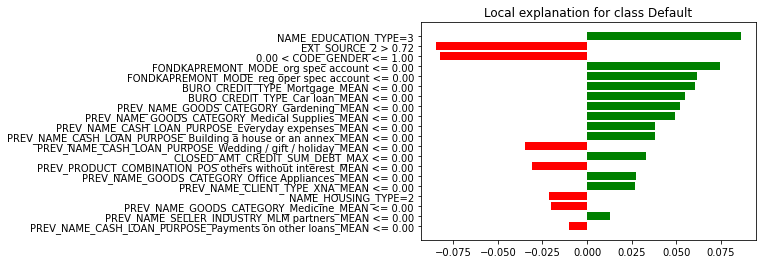

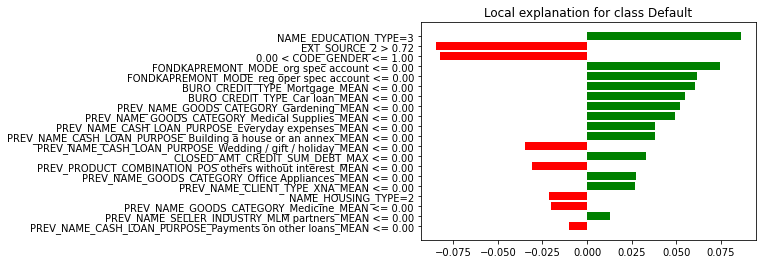

In [146]:
exp.as_pyplot_figure(label=1)

In [31]:
dill.dump_session('score_credit_4.p')